<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px"> 

# Capstone: Project Elimi-'Hate'

Note: This is part 2 of the code notebook covering the following :-

1. [Library Imports & Functions Creation](#1.-Library-Imports-&-Functions-Creation)
2. [Preparation for Modelling Part 2: Vectorization](#3.-Preparation-for-Modelling-Part-2:-Vectorization)
3. [Baseline Model](#3.-Baseline-Model)
4. [Alternative Models](#4.-Alternative-Models)
5. [Evaluation of Best Model](#5.-Evaluation-of-Best-Model)
6. [Summary of Notebook 2](#4.-Summary-of-Notebook-2)

## 1. Library Imports & Functions Creation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow
import warnings
from numpy.random import seed
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn import metrics
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.adapt import MLARAM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2 
from tqdm import tqdm
from warnings import simplefilter


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
def build_model(model,mlb_estimator,xtrain,ytrain,xtest,ytest):
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    prediction = clf.predict(xtest)
    label_names = ['disrespectful', 'insulting', 'offensive', 'discriminating', 'humiliating', 'hateful', 'dehumanizing']
    class_report = metrics.classification_report(y_test, prediction, target_names=label_names) 
    return print(class_report)

## 2. Preparation for Modelling Part 2: Vectorization

We shall proceed to :-
1. import the cleaned dataframe from previous notebook;
2. check and remove rows with null values arising from the import;
3. separate the target variables from the features;
4. apply train-test split; and
5. apply TF-IDF vectorization.

In [3]:
# Step 1: Importing the dataset and provide a recap
df = pd.read_csv('df_cleaned.csv')
df.head(2)

,comment_id,text,disrespectful,insulting,humiliating,discriminating,dehumanizing,offensive,hateful
0,1,white people trash,1,1,1,1,1,1,1
1,2,youve caught big gay known airborne dildo,1,1,1,1,0,1,1


In [4]:
# Step 2: Checking for null values
pd.DataFrame(df.isna().sum())
pd.DataFrame(df.isna().sum()).reset_index()
missing_df = pd.DataFrame(df.isna().sum()).reset_index()
missing_df.columns = ['col', 'num_nulls'] 
missing_df['%nulls'] = missing_df['num_nulls']*100/len(df)
missing_df = missing_df[missing_df['num_nulls']>0].sort_values(by=["%nulls"], ascending=False)
display(missing_df)

,col,num_nulls,%nulls
1,text,2,0.005055


In [5]:
# Drop null rows due to data import
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Extracting the targets 
targets = df[['disrespectful', 'insulting', 'humiliating', 'dehumanizing', 'discriminating','offensive', 'hateful']]
targets = targets.loc[:, ['disrespectful', 'insulting', 'offensive', 'discriminating', 'humiliating', 'hateful', 'dehumanizing']]

In [7]:
# Step 3: Preparing for train_test split
X = [[i] for i in df['text']]
y = targets  
X = np.array(X)
y = y.to_numpy()

In [8]:
print(f'Number of Rows Remaining for Modeling: {len(df)}.')

Number of Rows Remaining for Modeling: 39563.


In [9]:
# Step 4: Train-test split using random seed 27
np.random.seed(27)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.25)

In [10]:
# Changing from np array to list
X_train = [i[0] for i in X_train]
X_test = [i[0] for i in X_test]

In [11]:
# Step 5: Apply tf-idf vectorization
warnings.simplefilter(action='ignore', category=FutureWarning)
tfid = TfidfVectorizer(stop_words='english')
X_train = tfid.fit_transform(X_train)
X_test = tfid.transform(X_test)

In [12]:
X_train = pd.DataFrame.sparse.from_spmatrix(X_train, columns = tfid.get_feature_names())
X_test = pd.DataFrame.sparse.from_spmatrix(X_test, columns = tfid.get_feature_names())

Choice of vectorizer is most commonly between count vectorizer and Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer. Given that TF-IDF vectorizer is able to account for frequency of words present and uncover those which are more important for analysis, it is preferred over count vectorizer.

In [13]:
print(f'Number of Features from Train Dataset: {len(X_train. columns)}.')

Number of Features from Train Dataset: 43671.


In [14]:
print(f'Number of Features from Test Dataset: {len(X_train. columns)}.')

Number of Features from Test Dataset: 43671.


## 3. Baseline Model

### - Binary Relevance & Naives Bayes

We shall implement a baseline model using binary relevance and naives bayes for the multi-label classification tasks, which involves using 43671 word features to predict seven target labels (`disrespectful`, `insulting`, `offensive`, `discriminating`, `humiliating`, `hateful` & `dehumanizing`).

Binary relevance assumes each target label is mutually exclusive of each other. Naives bayes classified method is chose to accompany binary relevance as it is most commonly used for NLP tasks and requires the least processing power for modeling.

In [15]:
warnings.filterwarnings("ignore")
build_model(MultinomialNB(),BinaryRelevance,X_train,y_train,X_test,y_test)

                precision    recall  f1-score   support

 disrespectful       0.75      0.98      0.85      6899
     insulting       0.73      0.95      0.83      6166
     offensive       0.71      0.94      0.81      6043
discriminating       0.67      0.91      0.77      5861
   humiliating       0.73      0.81      0.77      5202
       hateful       0.81      0.41      0.55      3659
  dehumanizing       0.72      0.18      0.29      3301

     micro avg       0.72      0.81      0.76     37131
     macro avg       0.73      0.74      0.70     37131
  weighted avg       0.73      0.81      0.74     37131
   samples avg       0.61      0.60      0.58     37131



### Methodology for Evaluation

1. Classification report, which provides an overview of the precision, recall and f1-scores for each label and the labels collectively, is the preferred method for evaluation.
2. Of key importance is the f1-score, which is the harmonic mean of both precision and recall scores. Precision measures how well the model performs out of all predictions while recall measures how well the model performs out of all actual labels. In other words, increasing precision score means that the model is able to elimate false prediction better and increasing recall score means that the model is able to pick out those wrongly predicted actual labels better. Using f-1 score will allow us to strike a balance between precision and recall scores as they are often in tension with each other. 
3. Apart from individual f-1 scores, micro and macro average f-1 scores shall also taken into account for evaluation. Micro average f-1 score averages based on the different weightage of each label, while macro average f-1 score measures the average of the recall score of each label based on equal weightage.
4. F-1 score assumes equal weightage between precision and recall scores. Nevertheless, given the context of this project to pick out unhelpful comments, the priority is to make sure that as many of such comments are being flagged out throuh the model. Hence, in evaluating model with similar f-1 scores, recall scores will take slight priority over precision.

### Evaluation of Base Model: Binary Relevance & Naives Bayes

- **Individual f-1 Scores**: Base model is able to perform relatively well in f-1 scores for most labels apart from `hateful` and `dehumanizing`, which fared below 0.6. Given the project's focus on hate speech, the score of 0.55 is not ideal. Moreover, the 0.29 score for `dehumanizing` is also low.
- **Micro Avg & Macro Avg f-1 Scores**: The model fared better in macro average and micro average scores with macro average performing worse than micro average when assuming equal weightage for `hateful` and `dehumanizing` labels.
- **Precision vs. Recall Scores**: Of the well preforming labels (with f-1 scores above 0.75), recall performs better than precision. However, the opposite is true for `hateful` and `dehumanizing` labels. This means that the low f-1 scores of both labels are mainly due to their low recall scores. In other words, the model has the tendency to miss out on these true labels.
- **Summary**: In short, the base model leaves room for improvement, especially for the f-1 scores of both `hateful` and `dehumanizing` labels.

## 4. Alternative Models

### - Classifier Chain & Naives Bayes

As helpful as a base model, the assumption of binary relevance that each label is independent of the others does not hold true for the current multi-label classification task. It was established in the previous notebook that all labels are positively correlated to each other. Hence, in order to take into account of this relationship between labels, a more suitable model would be the classifer chain. It will predict each label sequentially by taking of the correlation between each label. As per the baseline model, naives bayes is also used.

In [16]:
warnings.filterwarnings("ignore")
build_model(MultinomialNB(),ClassifierChain,X_train,y_train,X_test,y_test)

                precision    recall  f1-score   support

 disrespectful       0.75      0.98      0.85      6899
     insulting       0.68      0.98      0.80      6166
     offensive       0.66      0.98      0.79      6043
discriminating       0.63      0.96      0.76      5861
   humiliating       0.58      0.99      0.73      5202
       hateful       0.53      0.87      0.66      3659
  dehumanizing       0.49      0.75      0.60      3301

     micro avg       0.63      0.95      0.76     37131
     macro avg       0.62      0.93      0.74     37131
  weighted avg       0.64      0.95      0.76     37131
   samples avg       0.55      0.70      0.60     37131



### Evaluation of Classifier Chain & Naives Bayes Model

- **Individual f-1 Scores**: As compared to the base model, this model is able to perform more consistently across the multi-labels with the worst performing label `dehumanizing` at 0.6. 
- **Micro Avg & Macro Avg f-1 Scores**: Given the improved f-1 scores of `hateful` and `dehumanizing` labels, the model is able to register better f-1 macro average and micro average scores. 
- **Precision vs. Recall Scores**: The improvement in f-1 scores came at the expense of the lower precision scores of each individual label. As compared to the base model, almost all (apart from `disrespectful`) saw lower precision scores. Precision macro average score dropped from 0.73 to 0.62, while recall macro average score improved from 0.74 to 0.93. 
- **Summary**: With both f-1 macro average and micro average scores at least 0.74, this model is promising. Given the relationship between labels, classifier chain model is a suitable model in theory. Practically, the model is also able to produce promising results. It is a model with potential for improvement through further tuning of parameters such as adjusting the alpha value for Naives Bayes or changing the order of labels for Classifier Chain. Nevertheless, the high trade-off between precision and recall of each label is concerning. 

### - Multi Label Adaptive Resonance Associative Map (MLARAM) 

Despite the promising scores of the Classifier Chain & Naives Bayes model, we shall exploring using more complex models to improve the scores. All the models from here on will be neutral network models. The first model is a pre-trained neural network model meant for multi-label classification task. Much like the previous model, the Multi Label Adaptive Resonance Associative Map (MLARAM) produces predictions based on relationships between labels. It works on a hierarchy extraction algorithm is based on building association rules from label co-occurrences. For more information on this model, you can refer to this [documentation](https://ieeexplore.ieee.org/document/5596699?signout=success).

In [17]:
# Need to convert X_train to np array for this model
X_train = np.array(X_train)
X_test = np.array(X_test)

In [18]:
classifier = MLARAM()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

In [19]:
label_names = ['disrespectful', 'insulting', 'offensive', 'discriminating', 'humiliating', 'hateful', 'dehumanizing']
print(classification_report(y_test, prediction,target_names=label_names))

                precision    recall  f1-score   support

 disrespectful       0.70      0.99      0.82      6899
     insulting       0.72      0.56      0.63      6166
     offensive       0.70      0.55      0.61      6043
discriminating       0.66      0.53      0.59      5861
   humiliating       0.63      0.51      0.57      5202
       hateful       0.52      0.37      0.43      3659
  dehumanizing       0.42      0.04      0.07      3301

     micro avg       0.67      0.56      0.61     37131
     macro avg       0.62      0.51      0.53     37131
  weighted avg       0.65      0.56      0.58     37131
   samples avg       0.64      0.44      0.45     37131



### Evaluation of MLARAM Model

There is no need to evaluate the model in details given the low micro average and macro average scores for precision, recall and f-1 scores across the board (less than 0.7 for all). Despite the room for further tuning, the above initial result of the default parameters shows that it might not be worth the effort.

### - Neural Network

Instead of relying on a pre-trained model, we shall now explore the option of training our own neural network model. Given the complexity of neural network, much can be done to vary the structure of the model (from adding more layers, different kinds of layers to adding different regularization techniques). Of course, a potential downside is the issue of overfitting arising due to the overcomplexity of the model. 

We shall first initiate a simple neural network.

In [20]:
# Initiating seed for reproducible result
from numpy.random import seed
seed(27)
import tensorflow
tensorflow.random.set_seed(27)

In [21]:
# Initiating neural network model
model = Sequential()
model.add(Dense(128, input_shape=(43671,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='sigmoid')) 

Metal device set to: Apple M1


2022-11-17 10:52:24.972346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 10:52:24.972452: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])

In [23]:
# Summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5590016   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 231       
Total params: 5,600,583
Trainable params: 5,600,583
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Modelling process
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=512)

2022-11-17 10:52:40.811617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-17 10:52:40.811923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-11-17 10:52:41.284647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.1330

2022-11-17 10:52:50.095763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 10s 128ms/step - loss: 0.6891 - accuracy: 0.1330 - val_loss: 0.6913 - val_accuracy: 0.0976
Epoch 2/10
58/58 [==============================] - 4s 77ms/step - loss: 0.6798 - accuracy: 0.1256 - val_loss: 0.6884 - val_accuracy: 0.1046
Epoch 3/10
58/58 [==============================] - 4s 71ms/step - loss: 0.6659 - accuracy: 0.1224 - val_loss: 0.6836 - val_accuracy: 0.1133
Epoch 4/10
58/58 [==============================] - 4s 68ms/step - loss: 0.6427 - accuracy: 0.1501 - val_loss: 0.6764 - val_accuracy: 0.0952
Epoch 5/10
58/58 [==============================] - 4s 68ms/step - loss: 0.6079 - accuracy: 0.1149 - val_loss: 0.6654 - val_accuracy: 0.0799
Epoch 6/10
58/58 [==============================] - 4s 67ms/step - loss: 0.5528 - accuracy: 0.1471 - val_loss: 0.6524 - val_accuracy: 0.1648
Epoch 7/10
58/58 [==============================] - 4s 67ms/step - loss: 0.4800 - accuracy: 0.1347 - val_loss: 0.6345 - val_accuracy: 0.0908
Epoch 8/10
58/58 [====

In [25]:
# Calculating prediction using 0.5 as the cut-off
y_pred = model.predict(X_test)
y_pred[(y_pred < 0.5)] = 0
y_pred[(y_pred >= 0.5)] = 1

2022-11-17 10:53:29.438529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [26]:
# Classification report of trained model
warnings.filterwarnings("ignore")
label_names = ['disrespectful', 'insulting', 'offensive', 'discriminating', 'humiliating', 'hateful', 'dehumanizing']
print(classification_report(y_test, y_pred,target_names=label_names))

                precision    recall  f1-score   support

 disrespectful       0.77      0.96      0.86      6899
     insulting       0.70      0.97      0.81      6166
     offensive       0.67      0.96      0.79      6043
discriminating       0.63      0.96      0.76      5861
   humiliating       0.65      0.93      0.76      5202
       hateful       0.00      0.00      0.00      3659
  dehumanizing       0.52      0.71      0.60      3301

     micro avg       0.67      0.84      0.75     37131
     macro avg       0.56      0.79      0.66     37131
  weighted avg       0.61      0.84      0.70     37131
   samples avg       0.58      0.63      0.58     37131



Given the tendency of overfitting for neural network models, computation of Mean Square Error (MSE) is necessary to gauge how the model fares on the train and test datasets. The graph below shows signs of overfitting. Despite tuning the model (such as increasing the rate Adam learning and increasing the batch size), overfitting is still present.

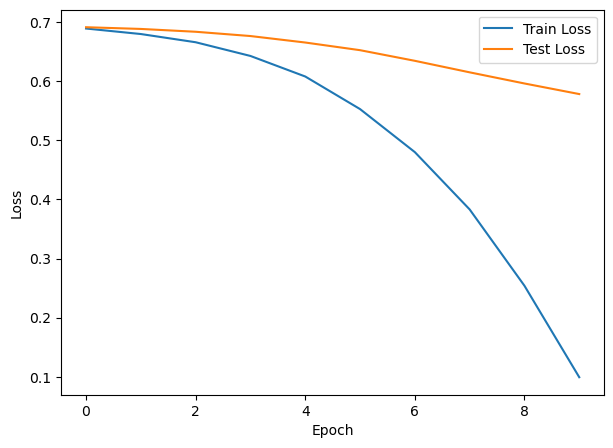

In [27]:
# Plotting graph to check for overfitting using MSE loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

### Evaluation of Neural Network Model

Despite the reasonable results of f1-score, the model is clearly overfitted even after the tuning of parameters found within the model. Hence, there will be additional measures such as early dropout, ridge regularization and dropping of nodes would be necessary to prevent overfitting. We shall explore these methods for our next neutral network model.

###  - Recurrent Neural Network (RNN)

In order to build a more robust model, a more drastic approach needs to be taken against overfitting. As mentioned, this model will accomodate more regularization approaches against overfitting. Moreover, given the nature of text, words should be held in relation of each other using LSTM (Long Term Short Memory) layering which is a type of RNN architecture (Recurrent Neural Network).

However, in order to set-up the new model, it will require first the embedding of each word features into vectors. To do so, we will shall use [GloVe](https://nlp.stanford.edu/projects/glove/), which stands for Global Vectors for Word Representation. This pre-trained word vector is provided by Stanford University. The specific model that trained on twitter dataset with 100 dimensions for each word shall be used.

Note: Given the size of the 

In [28]:
embeddings_index = {}
f = open('glove.twitter.27B.100d.txt',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

1193514it [00:12, 93171.94it/s]

Found 1193514 word vectors.


In [29]:
# Initiating the parameters baased on 
VOCABULARY_SIZE = 51627
MAX_LENGTH = 256

In [30]:
# Adjusting the text in dataframe
X1 = [[i] for i in df['text']]
X1 = np.array(X1)

In [31]:
# Initiating rain test split
np.random.seed(27)
X_train, y_train, X_test, y_test = iterative_train_test_split(X1, y, test_size = 0.25)

In [32]:
# Adjusting X_train and X_test to the right format
X_train = [i[0] for i in X_train]
X_test = [i[0] for i in X_test]

In [33]:
# Tokenizing both datasets
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE+1)
tokenizer.fit_on_texts(X_train)
xtrain_sequence = tokenizer.texts_to_sequences(X_train)
xtest_sequence = tokenizer.texts_to_sequences(X_test)

In [34]:
# Applying padding 
xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

In [35]:
# Embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|█████████████████████████████████| 43724/43724 [00:00<00:00, 553610.40it/s]


In [36]:
# Adjusting datasets
X_train = np.array(X_train)
X_test = np.array(X_test)

In [37]:
# Initiating seed for reproducible result
seed(27)
tensorflow.random.set_seed(27)

In [38]:
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index) + 1,
 100,
 weights=[embedding_matrix],
 input_length=MAX_LENGTH,
 trainable=False))
rnn_model.add(LSTM(128))
rnn_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.05)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(7, activation='sigmoid')) 

In [39]:
# Initiating early stop
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=2, 
                           mode='auto')

In [40]:
opt = Adam(learning_rate=0.001)
rnn_model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])

In [41]:
# Initiating rnn model
rnn_history = rnn_model.fit(
    xtrain_padding,
    y_train,
    validation_data=(xtest_padding, y_test),
    epochs=15,
    batch_size=512,
    callbacks=[early_stop]
)

Epoch 1/15


2022-11-17 10:54:36.492548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-17 10:54:36.808759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-17 10:54:38.021524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 4.7794 - accuracy: 0.6866

2022-11-17 10:55:00.565197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-17 10:55:00.614945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 28s 414ms/step - loss: 4.7794 - accuracy: 0.6866 - val_loss: 3.0006 - val_accuracy: 0.8131
Epoch 2/15
58/58 [==============================] - 21s 354ms/step - loss: 2.1047 - accuracy: 0.7077 - val_loss: 1.4222 - val_accuracy: 0.7916
Epoch 3/15
58/58 [==============================] - 21s 364ms/step - loss: 1.0971 - accuracy: 0.7501 - val_loss: 0.8688 - val_accuracy: 0.9006
Epoch 4/15
58/58 [==============================] - 21s 362ms/step - loss: 0.7434 - accuracy: 0.7849 - val_loss: 0.6520 - val_accuracy: 0.8363
Epoch 5/15
58/58 [==============================] - 21s 364ms/step - loss: 0.6125 - accuracy: 0.8051 - val_loss: 0.5766 - val_accuracy: 0.8681
Epoch 6/15
58/58 [==============================] - 20s 342ms/step - loss: 0.5637 - accuracy: 0.8227 - val_loss: 0.5575 - val_accuracy: 0.8327
Epoch 7/15
58/58 [==============================] - 20s 347ms/step - loss: 0.5444 - accuracy: 0.8260 - val_loss: 0.5396 - val_accuracy: 0.8868
Epoch 8/15

In [42]:
# Calculating prediction using 0.5 as the cut-off
y_pred = rnn_model.predict(xtest_padding)
y_pred[(y_pred < 0.5)] = 0
y_pred[(y_pred >= 0.5)] = 1

2022-11-17 10:59:27.627070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-11-17 10:59:27.651949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [43]:
warnings.filterwarnings("ignore")
label_names = ['disrespectful', 'insulting', 'offensive', 'discriminating', 'humiliating', 'hateful', 'dehumanizing']
print(classification_report(y_test, y_pred,target_names=label_names))

                precision    recall  f1-score   support

 disrespectful       0.82      0.93      0.87      6899
     insulting       0.77      0.92      0.84      6166
     offensive       0.74      0.89      0.81      6043
discriminating       0.71      0.87      0.78      5861
   humiliating       0.72      0.84      0.78      5202
       hateful       0.66      0.72      0.69      3659
  dehumanizing       0.58      0.55      0.57      3301

     micro avg       0.73      0.85      0.79     37131
     macro avg       0.71      0.82      0.76     37131
  weighted avg       0.73      0.85      0.78     37131
   samples avg       0.56      0.61      0.56     37131



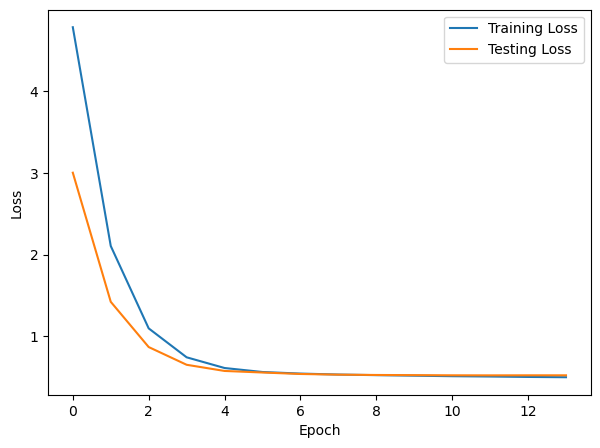

In [44]:
# Plotting graph to check for overfitting using MSE loss
train_loss = rnn_history.history['loss']
test_loss = rnn_history.history['val_loss']
plt.figure(figsize=(7, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

### Evaluation of RNN

Unlike the previous neural network model, the current RNN model is able to eliminate overfitting successfully. Despite the inherent trade-off between precision and recall scores, the model is able to register impressive scores of above 0.7 and above 0.8 for precision and recall scores respectively. The section below shall compare the model against all the other models.

## 5. Evaluation of Best Model

Index | Model | Precision Macro Avg |  Recall Macro Avg | f-1 Macro Avg | Remarks | 
|:----:|:----|:----:|:----:| :----:| :----|
|1| Binary Relevance & Naives Bayes | 0.73 | 0.74 |0.70 | Assumed labels are not related to each other |
|2| Classifier Chain & Naives Bayes | 0.62 | 0.93 |0.74 | Produced good f-1 score at the expense of precision |
|3| MLARAM | 0.62 | 0.51 |0.53 | Registered bad scores across  |
|4| Neural Network | 0.56 | 0.79 |0.66 | Clear overfitting  |
|5| RNN | 0.71 | 0.82 |0.76 | Best Model based on f-1 score |

Based on the above summary of models, RNN is clearly the best performing with a f-1 score of 0.76. Moreover, despite the close score with the Classifier Chain & Naives Bayes model, it was able to better address the issue of low precision score. With that, RNN is chosen as the best model. The model and its tokenizer will be exported for Streamlit API implementation.

In [45]:
# Exporting the tokenizer for Streamlit API
with open('rnn_token', 'wb') as files:
    pickle.dump(tokenizer, files)

In [46]:
# Exporting the model for Streamlit API
rnn_model.save('rnn_model.h5')

## 6. Summary of Notebook 2

In short, this notebook managed to achieve the following: 
1. Ran five different multi-label classification models including a base model;
2. Picked out the best model (RNN) using macro average score of f-1 score, recall and precision; and 
3. Exported the best model and its tokenizer to build Streamlit API.